# Machine Learning Trading Bot

In [240]:
# Initial imports
import numpy as np
import pandas as pd
import hvplot.pandas
from sklearn import svm
from pathlib import Path
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Disable false positive error message
pd.options.mode.chained_assignment = None

## Establish a Baseline Performance

In [241]:
# Import the OHLCV dataset into a dataframe
ohlcv_df = pd.read_csv(
    Path("./Resources/emerging_markets_ohlcv.csv"), 
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Use .head() to verify data
ohlcv_df.head()

,open,high,low,close,volume
date,,,,,
2015-01-21 09:30:00,23.83,23.83,23.83,23.83,100
2015-01-21 11:00:00,23.98,23.98,23.98,23.98,100
2015-01-22 15:00:00,24.42,24.42,24.42,24.42,100
2015-01-22 15:15:00,24.42,24.44,24.42,24.44,200
2015-01-22 15:30:00,24.46,24.46,24.46,24.46,200


In [242]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:, ["close"]]

# Use .pct_change() to generate daily returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values
signals_df = signals_df.dropna()

# Review the dataframe
signals_df

,close,Actual Returns
date,,
2015-01-21 11:00:00,23.98,0.006295
2015-01-22 15:00:00,24.42,0.018349
2015-01-22 15:15:00,24.44,0.000819
2015-01-22 15:30:00,24.46,0.000818
2015-01-26 12:30:00,24.33,-0.005315
...,...,...
2021-01-22 09:30:00,33.27,-0.006866
2021-01-22 11:30:00,33.35,0.002405
2021-01-22 13:45:00,33.42,0.002099


In [243]:
# Set the short and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (SMA)
signals_df["SMA_Fast"] = signals_df["close"].rolling(window=short_window).mean()
signals_df["SMA_Slow"] = signals_df["close"].rolling(window=long_window).mean()

# Drop all NaN values
signals_df = signals_df.dropna()

# Review the dataframe
signals_df

,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.32140
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.33080
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.33600
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.34110
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.34630
...,...,...,...,...
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745


In [244]:
# Initialize the new Signal column
signals_df["Signal"] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock
signals_df.loc[(signals_df["Actual Returns"] >= 0), "Signal"] = 1

# When Actual Returns are less than 0, generate signal to sell stock
signals_df.loc[(signals_df["Actual Returns"] < 0), "Signal"] = -1

# Review the dataframe
signals_df

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.32140,1.0
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.33080,1.0
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.33600,1.0
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.34110,1.0
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.34630,1.0
...,...,...,...,...,...
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0


In [245]:
# Review the value counts
signals_df["Signal"].value_counts()

 1.0    2368
-1.0    1855
Name: Signal, dtype: int64

In [246]:
# Calculate the strategy returns and add them to the signals_df dataframe
signals_df["Strategy Returns"] = signals_df["Actual Returns"] * signals_df["Signal"].shift()

# Review the dataframe
signals_df

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.32140,1.0,NaN
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.33080,1.0,0.000000
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.33600,1.0,0.000803
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.34110,1.0,0.000401
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.34630,1.0,0.001202
...,...,...,...,...,...,...
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0,0.002099


<AxesSubplot:title={'center':'Trading Algorithm Cumulative Returns'}, xlabel='Date', ylabel='Returns'>

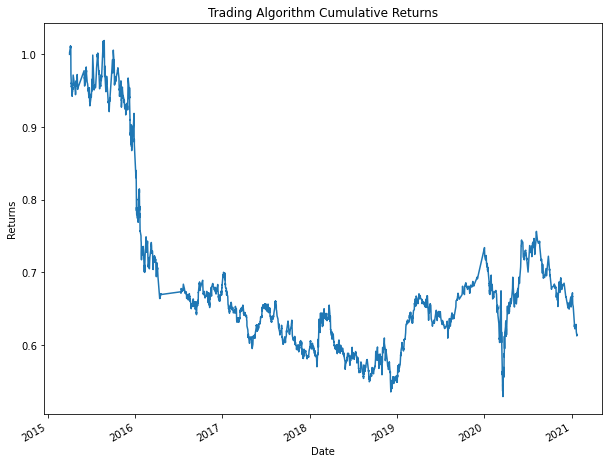

In [247]:
# Plot Strategy Returns
(1 + signals_df["Strategy Returns"]).cumprod().plot(
    title="Trading Algorithm Cumulative Returns",
    figsize=(10, 8),
    xlabel="Date",
    ylabel="Returns"
)

In [248]:
# Create the feature set (X) using the SMA_Fast and SMA_Slow columns
X = signals_df[["SMA_Fast", "SMA_Slow"]].shift().dropna()

# Use .head() to verify data
X.head()

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


In [249]:
# Create the feature set (y) using the Signal column
y = signals_df["Signal"]

# Review the value counts
y.value_counts()

 1.0    2368
-1.0    1855
Name: Signal, dtype: int64

In [250]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training start date
print(training_begin)

2015-04-02 15:00:00


In [251]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2015-07-02 15:00:00


In [252]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train dataframe
X_train

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463
...,...,...
2015-06-30 12:15:00,24.2150,25.2106
2015-06-30 14:00:00,24.1050,25.1930
2015-06-30 14:15:00,24.0775,25.1767


In [253]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test dataframe
X_test

,SMA_Fast,SMA_Slow
date,,
2015-07-06 10:00:00,24.1250,25.09190
2015-07-06 10:45:00,23.9700,25.06820
2015-07-06 14:15:00,23.8475,25.04580
2015-07-06 14:30:00,23.6725,25.02060
2015-07-07 11:30:00,23.4800,24.99510
...,...,...
2021-01-22 09:30:00,33.1725,30.36035
2021-01-22 11:30:00,33.2025,30.40215
2021-01-22 13:45:00,33.2725,30.44445


In [254]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Scale the X_train and X_test dataframes using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [255]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred

array([1., 1., 1., ..., 1., 1., 1.])

In [256]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.43      0.04      0.07      1804
         1.0       0.56      0.96      0.71      2288

    accuracy                           0.55      4092
   macro avg       0.49      0.50      0.39      4092
weighted avg       0.50      0.55      0.43      4092



In [257]:
# Create a predictions dataframe
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the dataframe
predictions_df["Predicted"] = svm_pred

# Add the actual returns to the dataframe
predictions_df["Actual Returns"] = signals_df["Actual Returns"]

# Add the strategy returns to the dataframe
predictions_df["Strategy Returns"] = predictions_df["Actual Returns"] * predictions_df["Predicted"]

# Review the dataframe
predictions_df

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-07-06 10:00:00,1.0,-0.025715,-0.025715
2015-07-06 10:45:00,1.0,0.007237,0.007237
2015-07-06 14:15:00,1.0,-0.009721,-0.009721
2015-07-06 14:30:00,1.0,-0.003841,-0.003841
2015-07-07 11:30:00,1.0,-0.018423,-0.018423
...,...,...,...
2021-01-22 09:30:00,1.0,-0.006866,-0.006866
2021-01-22 11:30:00,1.0,0.002405,0.002405
2021-01-22 13:45:00,1.0,0.002099,0.002099


<AxesSubplot:title={'center':'Cumulative Daily Returns vs Strategy Returns'}, xlabel='Date', ylabel='Returns'>

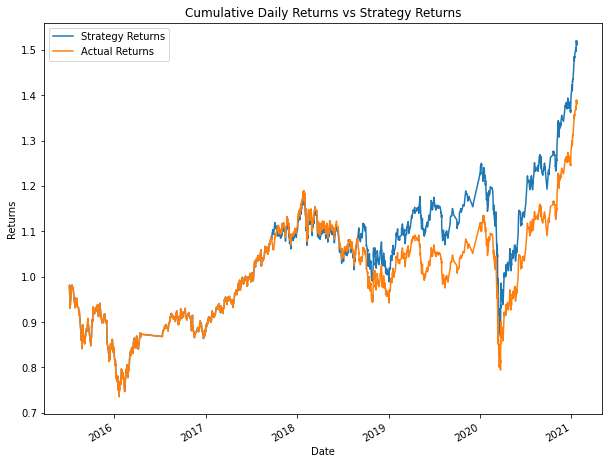

In [258]:
# Plot cumulative Actual Returns & Strategy Returns
(1 + predictions_df[["Strategy Returns", "Actual Returns"]]).cumprod().plot(
    title="Cumulative Daily Returns vs Strategy Returns",
    figsize=(10, 8),
    xlabel="Date",
    ylabel="Returns"
)

In [259]:
# Check cumulative returns
(1 + predictions_df[["Strategy Returns", "Actual Returns"]]).cumprod()

,Strategy Returns,Actual Returns
date,,
2015-07-06 10:00:00,0.974285,0.974285
2015-07-06 10:45:00,0.981336,0.981336
2015-07-06 14:15:00,0.971796,0.971796
2015-07-06 14:30:00,0.968063,0.968063
2015-07-07 11:30:00,0.950228,0.950228
...,...,...
2021-01-22 09:30:00,1.509892,1.379925
2021-01-22 11:30:00,1.513523,1.383243
2021-01-22 13:45:00,1.516700,1.386147


## Evaluate a New Machine Learning Classifier

In [260]:
# Initiate the model instance
model = AdaBoostClassifier()

In [261]:
# Fit the model using the training data
model = model.fit(X_train_scaled, y_train)

# Use the testing dataset to generate the predictions
pred = model.predict(X_test_scaled)

# Review the predicted values
pred

array([ 1., -1., -1., ...,  1.,  1.,  1.])

In [262]:
# Use a classification report to evaluate the model using the predictions and testing data
report = classification_report(y_test, pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

        -1.0       0.44      0.08      0.13      1804
         1.0       0.56      0.92      0.70      2288

    accuracy                           0.55      4092
   macro avg       0.50      0.50      0.41      4092
weighted avg       0.51      0.55      0.45      4092



In [263]:
# Create a predictions dataframe
ada_pred_df = pd.DataFrame(index=X_test.index)

# Add the new model predictions to the dataframe
ada_pred_df["Predicted"] = pred

# Add the actual returns to the dataframe
ada_pred_df["Actual Returns"] = signals_df["Actual Returns"]

# Add the strategy returns to the dataframe
ada_pred_df["Strategy Returns"] = ada_pred_df["Actual Returns"] * ada_pred_df["Predicted"]

# Review the dataframe
ada_pred_df

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-07-06 10:00:00,1.0,-0.025715,-0.025715
2015-07-06 10:45:00,-1.0,0.007237,-0.007237
2015-07-06 14:15:00,-1.0,-0.009721,0.009721
2015-07-06 14:30:00,-1.0,-0.003841,0.003841
2015-07-07 11:30:00,-1.0,-0.018423,0.018423
...,...,...,...
2021-01-22 09:30:00,1.0,-0.006866,-0.006866
2021-01-22 11:30:00,1.0,0.002405,0.002405
2021-01-22 13:45:00,1.0,0.002099,0.002099


<AxesSubplot:title={'center':'Cumulative Daily Returns vs Strategy Returns - New Model'}, xlabel='Date', ylabel='Returns'>

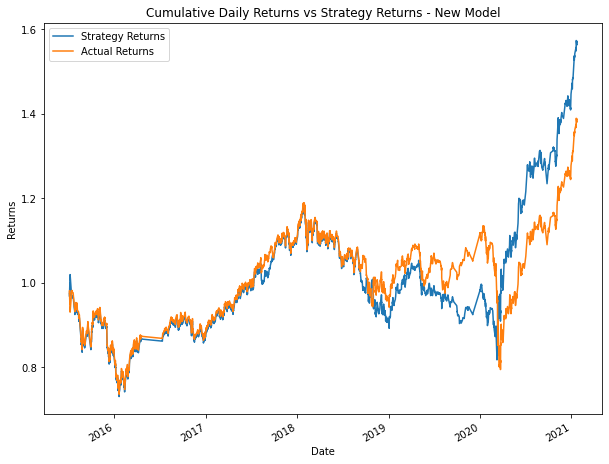

In [264]:
# Plot cumulative Actual Returns & Strategy Returns
(1 + ada_pred_df[["Strategy Returns", "Actual Returns"]]).cumprod().plot(
    title="Cumulative Daily Returns vs Strategy Returns - New Model",
    figsize=(10, 8),
    xlabel="Date",
    ylabel="Returns"
)

In [265]:
# Check cumulative returns
(1 + ada_pred_df[["Strategy Returns", "Actual Returns"]]).cumprod()

,Strategy Returns,Actual Returns
date,,
2015-07-06 10:00:00,0.974285,0.974285
2015-07-06 10:45:00,0.967234,0.981336
2015-07-06 14:15:00,0.976636,0.971796
2015-07-06 14:30:00,0.980388,0.968063
2015-07-07 11:30:00,0.998450,0.950228
...,...,...
2021-01-22 09:30:00,1.562834,1.379925
2021-01-22 11:30:00,1.566592,1.383243
2021-01-22 13:45:00,1.569880,1.386147
